# Global Imports

In [106]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random

random.seed(42)

# Local Imports

In [107]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [108]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Echo"

# Define Paths
Workspace

In [109]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [110]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)


# Helper Functions

In [111]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [112]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels

In [113]:

labeled_image_paths: list[tuple[str, str]] = []

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))


# Load Dataset

In [114]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.35,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




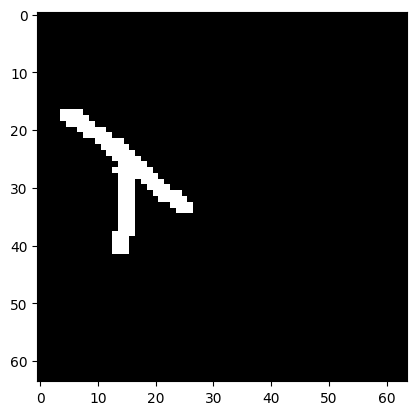

tensor([0., 0., 0., 0., 0., 1., 0.])


In [115]:
for im, lab in train_char_dataset:
    plt.imshow(
        rearrange(im, "1 h w -> h w")*255, 
        cmap="gray"
    )
    plt.show()
    print(lab)
    break

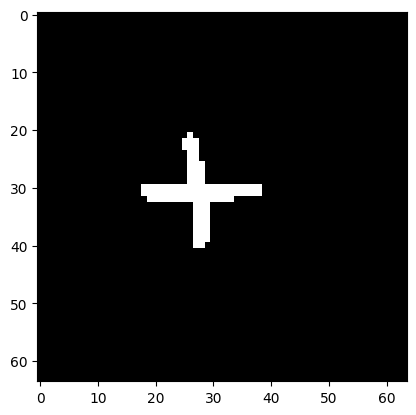

tensor([0., 0., 1., 0., 0., 0., 0.])


In [116]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [117]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

# Define Model Hyperparameters

In [118]:

model_checkpoint_path: str = os.path.join(
    model_save_dirpath,
    "FoxTrot_epoch116_trainacc0.86029_valacc1.0_Tloss0.024372_Vloss0.0031614_lr0.001.pkl"
)

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 16, 16, 16, 16, 16, 32),
        "fully_connected_features": (7,),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.05,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": model_checkpoint_path
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.001,
        "weight_decay": 0.0001
    }
]


In [119]:
len(val_dataloader)

5

# Train

In [ ]:


epoch_log: EpochLogs
for epoch_log in grid_search(
    model_factory=AllCNN2D,
    all_model_parameters=all_model_parameters,
    optim_factory=AdamW,
    all_optim_params=all_optim_parameters,
    epochs=10000,
    criterion=nn.CrossEntropyLoss(),
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    lr_decay_window_size=10,
    lr_decay_minimum=0.0,
    scheduler_scale=0.85,
    device="cuda"
):
    train_logpoints: list[LogPoint] = epoch_log.train_logs
    val_logpoints: list[LogPoint] = epoch_log.val_logs
    
    
    train_count: int = 0
    val_count: int = 0
    
    train_losses_tally: float = 0.0
    val_losses_tally: float = 0.0
    
    train_correct_tally: int = 0
    val_correct_tally: int = 0
    
    for log_point in train_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        train_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        train_losses_tally += torch.sum(log_point.loss)
        
        train_count += len(y_hat_pred)
        
    for log_point in val_logpoints: 
        
        y_hat_pred: torch.Tensor = torch.argmax(
            log_point.y_hat, 
            axis=-1
        ).detach().cpu()
        
        y_pred: torch.Tensor = torch.argmax(
            log_point.y, axis=-1
        ).detach().cpu()

        val_correct_tally += torch.sum(y_hat_pred==y_pred)
        
        val_losses_tally += torch.sum(log_point.loss)
        
        val_count += len(y_hat_pred)
        
    train_accuracy: float = train_correct_tally/train_count
    val_accuracy: float = val_correct_tally/val_count
    
    train_loss: float = train_losses_tally/train_count
    val_loss: float = val_losses_tally/val_count
    
    cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
    
    model_checkpoint_path: str = os.path.join(
        model_save_dirpath,
        f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}_Tloss{train_loss:.5}_Vloss{val_loss:.5}_lr{cur_learning_rate}.pkl"
    )
    
    with open(model_checkpoint_path, "wb") as f:
        torch.save(epoch_log.model.state_dict(), f)
    
    print(f"Train Accuracy      : {train_accuracy}")
    print(f"Val Accuracy        : {val_accuracy}")
    print(f"Loss                : {train_loss}")
    print(f"Val Loss            : {val_loss}")
    print(f"Learning Rate       : {cur_learning_rate}")
    
    log(
        epoch_log.epoch,
        train_accuracy,
        train_loss,
        val_accuracy,
        val_loss,
        cur_learning_rate
    )

Loaded: encoder_conv_blocks.0.0.weight
Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Loaded: encoder_conv_blocks.1.0.weight
Loaded: encoder_conv_blocks.1.0.bias
Loaded: encoder_conv_blocks.1.2.weight
Loaded: encoder_conv_blocks.1.2.bias
Loaded: encoder_conv_blocks.1.2.running_mean
Loaded: encoder_conv_blocks.1.2.running_var
Loaded: encoder_conv_blocks.1.2.num_batches_tracked
Loaded: encoder_conv_blocks.1.4.weight
Loaded: encoder_conv_blocks.1.4.bias
Loaded: encoder_conv_blocks.1.6.weight
Loaded

Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.8639705777168274
Val Accuracy        : 1.0
Loss                : 0.024309678003191948
Val Loss            : 0.0039182924665510654
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Train Accuracy      : 0.8235294222831726
Val Accuracy        : 0.9855072498321533
Loss                : 0.030422711744904518
Val Loss            : 0.004863423760980368
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Train Accuracy      : 0.8639705777168274
Val Accuracy        : 0.9855072498321533
Loss                : 0.027395637705922127
Val Loss            : 0.005951721221208572
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Train Accuracy      : 0.8639705777168274
Val Accuracy        : 0.9420289993286133
Loss                : 0.025167565792798996
Val Loss            : 0.012202262878417969
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.8529411554336548
Val Accuracy        : 1.0
Loss                : 0.02662508562207222
Val Loss            : 0.0032008762937039137
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Train Accuracy      : 0.8235294222831726
Val Accuracy        : 1.0
Loss                : 0.030921459197998047
Val Loss            : 0.004775445908308029
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.841911792755127
Val Accuracy        : 1.0
Loss                : 0.0265335850417614
Val Loss            : 0.0030622174963355064
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.8529411554336548
Val Accuracy        : 0.9855072498321533
Loss                : 0.02580777369439602
Val Loss            : 0.003818236058577895
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Train Accuracy      : 0.8676470518112183
Val Accuracy        : 0.9855072498321533
Loss                : 0.03224730119109154
Val Loss            : 0.0051588197238743305
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.9710144996643066
Loss                : 0.024359147995710373
Val Loss            : 0.009504958055913448
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.95652174949646
Loss                : 0.023076357319951057
Val Loss            : 0.007353993598371744
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.8308823704719543
Val Accuracy        : 0.9710144996643066
Loss                : 0.026608675718307495
Val Loss            : 0.007179862353950739
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8602941036224365
Val Accuracy        : 0.9710144996643066
Loss                : 0.027741916477680206
Val Loss            : 0.005433287005871534
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.023587428033351898
Val Loss            : 0.005557442083954811
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 0.9855072498321533
Loss                : 0.021866457536816597
Val Loss            : 0.003580448217689991
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.023794805631041527
Val Loss            : 0.004272173158824444
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.8823529481887817
Val Accuracy        : 0.9855072498321533
Loss                : 0.02252730168402195
Val Loss            : 0.005083891563117504
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 0.9855072498321533
Loss                : 0.024192169308662415
Val Loss            : 0.0033163055777549744
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.8272058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.03395865485072136
Val Loss            : 0.003926959820091724
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 0.9710144996643066
Loss                : 0.020909028127789497
Val Loss            : 0.004402485676109791
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8051470518112183
Val Accuracy        : 0.9710144996643066
Loss                : 0.034449368715286255
Val Loss            : 0.005336701404303312
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.9855072498321533
Loss                : 0.027000052854418755
Val Loss            : 0.005853280425071716
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 0.9710144996643066
Loss                : 0.02174117974936962
Val Loss            : 0.004186367150396109
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8566176295280457
Val Accuracy        : 0.9855072498321533
Loss                : 0.025605442002415657
Val Loss            : 0.002636711345985532
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.841911792755127
Val Accuracy        : 0.9855072498321533
Loss                : 0.02792295627295971
Val Loss            : 0.004072722513228655
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Accuracy      : 0.8676470518112183
Val Accuracy        : 1.0
Loss                : 0.025664255023002625
Val Loss            : 0.005342300049960613
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 1.0
Loss                : 0.02069692313671112
Val Loss            : 0.0021677569020539522
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.875
Val Accuracy        : 1.0
Loss                : 0.022594206035137177
Val Loss            : 0.004066803026944399
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 0.9855072498321533
Loss                : 0.02648918330669403
Val Loss            : 0.0034647423308342695
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 0.9855072498321533
Loss                : 0.023318156599998474
Val Loss            : 0.005098707042634487
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.9855072498321533
Loss                : 0.026795852929353714
Val Loss            : 0.004861983470618725
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8566176295280457
Val Accuracy        : 0.95652174949646
Loss                : 0.025363868102431297
Val Loss            : 0.004989000968635082
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 1.0
Loss                : 0.021553419530391693
Val Loss            : 0.0022022428456693888
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8382353186607361
Val Accuracy        : 1.0
Loss                : 0.029162127524614334
Val Loss            : 0.0018632614519447088
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Train Accuracy      : 0.9264705777168274
Val Accuracy        : 1.0
Loss                : 0.0184743981808424
Val Loss            : 0.0017457576468586922
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8602941036224365
Val Accuracy        : 1.0
Loss                : 0.023516207933425903
Val Loss            : 0.0023747547529637814
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9154411554336548
Val Accuracy        : 1.0
Loss                : 0.01573185995221138
Val Loss            : 0.0021214119624346495
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 1.0
Loss                : 0.02482415735721588
Val Loss            : 0.0023996965028345585
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8676470518112183
Val Accuracy        : 0.9855072498321533
Loss                : 0.025602564215660095
Val Loss            : 0.00294425874017179
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 0.9855072498321533
Loss                : 0.02556091733276844
Val Loss            : 0.009778909385204315
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.875
Val Accuracy        : 0.9855072498321533
Loss                : 0.024654075503349304
Val Loss            : 0.0059341005980968475
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.845588207244873
Val Accuracy        : 0.9130434989929199
Loss                : 0.02603953890502453
Val Loss            : 0.011983528733253479
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 1.0
Loss                : 0.0238806065171957
Val Loss            : 0.004765236750245094
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8272058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.028186963871121407
Val Loss            : 0.0032811223063617945
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.020231489092111588
Val Loss            : 0.0026435928884893656
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Accuracy      : 0.8970588445663452
Val Accuracy        : 0.9855072498321533
Loss                : 0.019911397248506546
Val Loss            : 0.004069301299750805
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8529411554336548
Val Accuracy        : 1.0
Loss                : 0.025560474023222923
Val Loss            : 0.0018526138737797737
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 0.9710144996643066
Loss                : 0.024760769680142403
Val Loss            : 0.01069303322583437
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 1.0
Loss                : 0.02363775670528412
Val Loss            : 0.0049074855633080006
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.875
Val Accuracy        : 0.9710144996643066
Loss                : 0.021846266463398933
Val Loss            : 0.0036781823728233576
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 1.0
Loss                : 0.0210824366658926
Val Loss            : 0.0028154130559414625
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 1.0
Loss                : 0.02434801310300827
Val Loss            : 0.0022314090747386217
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.875
Val Accuracy        : 0.9855072498321533
Loss                : 0.0247800275683403
Val Loss            : 0.003386375494301319
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 0.9855072498321533
Loss                : 0.018251029774546623
Val Loss            : 0.0031533227302134037
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.9855072498321533
Loss                : 0.022996535524725914
Val Loss            : 0.002677537966519594
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9007353186607361
Val Accuracy        : 1.0
Loss                : 0.0177898108959198
Val Loss            : 0.003291489090770483
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 0.9855072498321533
Loss                : 0.0213942788541317
Val Loss            : 0.0031025863718241453
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Accuracy      : 0.8566176295280457
Val Accuracy        : 0.9855072498321533
Loss                : 0.028113478794693947
Val Loss            : 0.005282609257847071
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 0.9855072498321533
Loss                : 0.019281886518001556
Val Loss            : 0.005380087532103062
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 0.9855072498321533
Loss                : 0.018236743286252022
Val Loss            : 0.0039390153251588345
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 0.9855072498321533
Loss                : 0.02095320075750351
Val Loss            : 0.004152403213083744
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 0.9855072498321533
Loss                : 0.017019052058458328
Val Loss            : 0.004445012658834457
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8676470518112183
Val Accuracy        : 1.0
Loss                : 0.019529763609170914
Val Loss            : 0.0028179960791021585
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 0.9710144996643066
Loss                : 0.018595591187477112
Val Loss            : 0.006379319354891777
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 1.0
Loss                : 0.021154822781682014
Val Loss            : 0.0028554366435855627
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 0.9710144996643066
Loss                : 0.021450504660606384
Val Loss            : 0.007728909142315388
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 1.0
Loss                : 0.019492728635668755
Val Loss            : 0.0021974986884742975
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8713235259056091
Val Accuracy        : 0.9855072498321533
Loss                : 0.024382667616009712
Val Loss            : 0.003439512336626649
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9007353186607361
Val Accuracy        : 1.0
Loss                : 0.0210262518376112
Val Loss            : 0.0037380382418632507
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 0.9855072498321533
Loss                : 0.021725071594119072
Val Loss            : 0.002770163118839264
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8970588445663452
Val Accuracy        : 0.9855072498321533
Loss                : 0.019296865910291672
Val Loss            : 0.0047073690220713615
Learning Rate       : 0.00085


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 0.9855072498321533
Loss                : 0.022145166993141174
Val Loss            : 0.0054209111258387566
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8676470518112183
Val Accuracy        : 0.9855072498321533
Loss                : 0.024420825764536858
Val Loss            : 0.004666057415306568
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 1.0
Loss                : 0.021254267543554306
Val Loss            : 0.002818482695147395
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 1.0
Loss                : 0.016783641651272774
Val Loss            : 0.002230121986940503
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9301470518112183
Val Accuracy        : 1.0
Loss                : 0.01656205579638481
Val Loss            : 0.0019801293965429068
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 1.0
Loss                : 0.01912383921444416
Val Loss            : 0.0015766527503728867
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 1.0
Loss                : 0.014784709550440311
Val Loss            : 0.002166127786040306
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8786764740943909
Val Accuracy        : 1.0
Loss                : 0.02129504643380642
Val Loss            : 0.0030440641567111015
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 1.0
Loss                : 0.020567359402775764
Val Loss            : 0.00145321199670434
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 1.0
Loss                : 0.019032983109354973
Val Loss            : 0.001650773105211556
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8970588445663452
Val Accuracy        : 1.0
Loss                : 0.017060037702322006
Val Loss            : 0.002035687444731593
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 1.0
Loss                : 0.01982073113322258
Val Loss            : 0.0010790496598929167
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 1.0
Loss                : 0.018961498513817787
Val Loss            : 0.0017261662287637591
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 1.0
Loss                : 0.02545672282576561
Val Loss            : 0.0019006228540092707
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 1.0
Loss                : 0.019728321582078934
Val Loss            : 0.0016608231235295534
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.9007353186607361
Val Accuracy        : 1.0
Loss                : 0.017704900354146957
Val Loss            : 0.0019100543577224016
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9264705777168274
Val Accuracy        : 0.9855072498321533
Loss                : 0.014161713421344757
Val Loss            : 0.003328078892081976
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 0.9855072498321533
Loss                : 0.015033043920993805
Val Loss            : 0.002198831643909216
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 1.0
Loss                : 0.016978394240140915
Val Loss            : 0.0018402979476377368
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9485294222831726
Val Accuracy        : 1.0
Loss                : 0.011252544820308685
Val Loss            : 0.0024206251837313175
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 1.0
Loss                : 0.016648827120661736
Val Loss            : 0.0023121146950870752
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9411764740943909
Val Accuracy        : 1.0
Loss                : 0.011846591718494892
Val Loss            : 0.0014732617419213057
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.9522058963775635
Val Accuracy        : 1.0
Loss                : 0.011781612411141396
Val Loss            : 0.0017645452171564102
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 1.0
Loss                : 0.01597253419458866
Val Loss            : 0.0016942332731559873
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9154411554336548
Val Accuracy        : 1.0
Loss                : 0.01616578735411167
Val Loss            : 0.0014904951676726341
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.016339413821697235
Val Loss            : 0.0016709471819922328
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 1.0
Loss                : 0.01895415596663952
Val Loss            : 0.0018433965742588043
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 0.9855072498321533
Loss                : 0.016791168600320816
Val Loss            : 0.0038097344804555178
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 0.9855072498321533
Loss                : 0.015334516763687134
Val Loss            : 0.00490019004791975
Learning Rate       : 0.0007224999999999999


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.8860294222831726
Val Accuracy        : 0.9855072498321533
Loss                : 0.022339142858982086
Val Loss            : 0.002522067865356803
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.01618771255016327
Val Loss            : 0.001459432765841484
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 1.0
Loss                : 0.017588334158062935
Val Loss            : 0.001465928158722818
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8970588445663452
Val Accuracy        : 0.9855072498321533
Loss                : 0.019743075594305992
Val Loss            : 0.003299335716292262
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9264705777168274
Val Accuracy        : 1.0
Loss                : 0.015772921964526176
Val Loss            : 0.0013809642987325788
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.8970588445663452
Val Accuracy        : 0.9855072498321533
Loss                : 0.021684803068637848
Val Loss            : 0.002519676461815834
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 0.9855072498321533
Loss                : 0.01539753470569849
Val Loss            : 0.002386540174484253
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.8823529481887817
Val Accuracy        : 0.9855072498321533
Loss                : 0.023037249222397804
Val Loss            : 0.0025354588869959116
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Train Accuracy      : 0.904411792755127
Val Accuracy        : 1.0
Loss                : 0.019713785499334335
Val Loss            : 0.001704189577139914
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 1.0
Loss                : 0.0183426346629858
Val Loss            : 0.0014512608759105206
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.013718720525503159
Val Loss            : 0.0015989623498171568
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9375
Val Accuracy        : 1.0
Loss                : 0.01222983282059431
Val Loss            : 0.0019244637805968523
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Train Accuracy      : 0.8897058963775635
Val Accuracy        : 1.0
Loss                : 0.01712713949382305
Val Loss            : 0.0010910563869401813
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9522058963775635
Val Accuracy        : 1.0
Loss                : 0.012013440951704979
Val Loss            : 0.0009042064775712788
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 1.0
Loss                : 0.014134609140455723
Val Loss            : 0.001189615111798048
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8823529481887817
Val Accuracy        : 1.0
Loss                : 0.019430628046393394
Val Loss            : 0.0009739383822306991
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.9154411554336548
Val Accuracy        : 1.0
Loss                : 0.01731787621974945
Val Loss            : 0.0015669966815039515
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.02105511724948883
Val Loss            : 0.003876052564010024
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.9007353186607361
Val Accuracy        : 0.95652174949646
Loss                : 0.01925455965101719
Val Loss            : 0.010237997397780418
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.01547100581228733
Val Loss            : 0.0019821259193122387
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.9375
Val Accuracy        : 1.0
Loss                : 0.012343117035925388
Val Loss            : 0.00208040582947433
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Train Accuracy      : 0.9558823704719543
Val Accuracy        : 1.0
Loss                : 0.011042275466024876
Val Loss            : 0.0020451999735087156
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 0.9855072498321533
Loss                : 0.016632363200187683
Val Loss            : 0.001690237782895565
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 0.9855072498321533
Loss                : 0.016199657693505287
Val Loss            : 0.002155953086912632
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 1.0
Loss                : 0.01500443834811449
Val Loss            : 0.0014824786921963096
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 0.9855072498321533
Loss                : 0.01631244271993637
Val Loss            : 0.0035719936713576317
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 1.0
Loss                : 0.014606851153075695
Val Loss            : 0.001855187234468758
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9338235259056091
Val Accuracy        : 1.0
Loss                : 0.013379924930632114
Val Loss            : 0.0009938895236700773
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.8933823704719543
Val Accuracy        : 1.0
Loss                : 0.0186242014169693
Val Loss            : 0.0012779259122908115
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Train Accuracy      : 0.9264705777168274
Val Accuracy        : 1.0
Loss                : 0.013940106146037579
Val Loss            : 0.0024452954530715942
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 0.9710144996643066
Loss                : 0.015063084661960602
Val Loss            : 0.002620670711621642
Learning Rate       : 0.000614125


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train Accuracy      : 0.9227941036224365
Val Accuracy        : 1.0
Loss                : 0.015439935028553009
Val Loss            : 0.0014822101220488548
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9411764740943909
Val Accuracy        : 1.0
Loss                : 0.011283868923783302
Val Loss            : 0.0012607271783053875
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9411764740943909
Val Accuracy        : 1.0
Loss                : 0.013453160412609577
Val Loss            : 0.0019123218953609467
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9154411554336548
Val Accuracy        : 1.0
Loss                : 0.016872305423021317
Val Loss            : 0.0010107599664479494
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9117646813392639
Val Accuracy        : 1.0
Loss                : 0.016625327989459038
Val Loss            : 0.0012517800787463784
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9338235259056091
Val Accuracy        : 1.0
Loss                : 0.013936109840869904
Val Loss            : 0.0012827967293560505
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.908088207244873
Val Accuracy        : 1.0
Loss                : 0.01595478691160679
Val Loss            : 0.0019645891152322292
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.9301470518112183
Val Accuracy        : 1.0
Loss                : 0.017213817685842514
Val Loss            : 0.00174847396556288
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9191176295280457
Val Accuracy        : 0.9855072498321533
Loss                : 0.01679847575724125
Val Loss            : 0.003469614079222083
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Train Accuracy      : 0.9154411554336548
Val Accuracy        : 1.0
Loss                : 0.015415233559906483
Val Loss            : 0.0016696556704118848
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9264705777168274
Val Accuracy        : 0.9855072498321533
Loss                : 0.016759799793362617
Val Loss            : 0.0022359841968864202
Learning Rate       : 0.00052200625


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Train Accuracy      : 0.9485294222831726
Val Accuracy        : 1.0
Loss                : 0.011670767329633236
Val Loss            : 0.0008761074277572334
Learning Rate       : 0.00044370531249999997


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Train Accuracy      : 0.9301470518112183
Val Accuracy        : 1.0
Loss                : 0.013685761950910091
Val Loss            : 0.0010145839769393206
Learning Rate       : 0.00044370531249999997


Validating Model...:  40%|████      | 2/5 [00:01<00:02,  1.20it/s]